# Importation des librairies:

In [105]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import os
import email
import email.policy
from email.message import EmailMessage
import re
import nltk
from nltk.stem import PorterStemmer


# Lecture des fichiers (Emails)

In [106]:
easy_ham_path = 'C:/Users/DELL/OneDrive/Bureau/AARN/AARN/easy_ham/easy_ham'
hard_ham_path = 'C:/Users/DELL/OneDrive/Bureau/AARN/AARN/hard_ham/hard_ham'
spam_emails_path = 'C:/Users/DELL/OneDrive/Bureau/AARN/AARN/spam_2/spam_2'

# Lecture et traitement de contenu des emails 

get_data lit le contenu des fichiers ham et spam, traite le contenu pour extraire le corps du courrier électronique, puis stocke le corps et l'étiquette dans un dictionnaire et ajoute ce dictionnaire à une liste de données.
La fonction renvoie la liste de données contenant le corps et l'étiquette de chaque courrier électronique dans le répertoire, 0 ham et 1 spam.
Si le courrier électronique contient des erreurs lors de la lecture du fichier, le nom du fichier est ajouté à une liste appelée invalid_list.

In [107]:
invalid_list = []
def get_data(path, label):
    data = []
    files = os.listdir(path) 
    
    for file in files:
        if os.path.isfile(os.path.join(path, file)):
            try:
                file = open(os.path.join(path, file),'r',errors='ignore')
                content = file.read()
                msg = email.message_from_string(content)
                if msg.is_multipart():
                    body = []
                    for payload in msg.get_payload():
                        # if payload.is_multipart(): ...
                        body.append(payload.get_payload())
                    body = ' '.join(body)

                else:
                    body = msg.get_payload()
                dic = {'Email': body, 'Label': label}
                data.append(dic)
            except:
                invalid_list.append(file)
        file.close()
    
    return data

In [108]:
easy_ham = get_data(easy_ham_path, 0)
hard_ham = get_data(hard_ham_path, 0)
# the spam emails
spam = get_data(spam_emails_path, 1)


Faire un mélange aléatoire qui permet d'éviter que l'ordre des données dans les tableaux affecte les performances des modèles d'apprentissage automatique qui seront entraînés par la suite. 

In [109]:
np.random.shuffle(easy_ham)
np.random.shuffle(hard_ham)
np.random.shuffle(spam)

Test d'affchage

In [110]:
print(len(easy_ham))
print(spam[9]["Email"])
print(spam[8].keys())
print(type(hard_ham[9]))

2546
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<html>
<head>
	<title>VistaPrint.com</title>
</head>

<body><center>
<a href="http://ct2.consumertoday.net/cgi-bin14/flo?y=hEY0CCzME0D40EW0AN"><table width="565" cellspacing="0" cellpadding="0" border="0">
<tr>
    <td width="331"><a href="http://ct2.consumertoday.net/cgi-bin14/flo?y=hEY0CCzME0D40EW0AN"><img src="http://images.sandbox.com/images/email/vistaprint_KIT_FREE_text.gif" width="331" height="128" border="0" alt="" title="VistaPrint.com"></a></td>
    <td rowspan="2" width="234"><a href="http://ct2.consumertoday.net/cgi-bin14/flo?y=hEY0CCzME0D40EW0AN"><img src="http://images.sandbox.com/images/email/vistaprint_KIT_two_ladies.jpg" width="234" height="234" border="0" title="VistaPrint.com" alt=""></a></td>
</tr>
<tr>
    <td width="331"><a href="http://ct2.consumertoday.net/cgi-bin14/flo?y=hEY0CCzME0D40EW0AN"><img src="http://images.sandbox.com/images/email/vistaprint_KIT_stay_close.gif" width="331" height="106"

On crée trois DataFrames en utilisant les listes easy_ham, hard_ham et spam. Chaque liste contient des dictionnaires représentant des emails, avec les clés 'Email' pour le contenu de l'email et 'Label' pour le type de l'email (ham ou spam)

In [111]:
easy_ham_df = pd.DataFrame(easy_ham)
hard_ham_df = pd.DataFrame(hard_ham)
spam_df = pd.DataFrame(spam)
hard_ham_df

,Email,Label
0,"Hallo Xxxxxxxxx Yyyyyyy,\n\nHEUTE, 03. Juli, i...",0
1,<html>\n<head>\n<title>CNET Investor Dispatch<...,0
2,<html>\n<head>\n<title>Tech Update Today</titl...,0
3,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0
4,<html>\n<head>\n <title>THE WEEK IN REV...,0
...,...,...
244,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,0
245,"firewalls Digest\tThu, 25 Jul 2002\tVolume: 01...",0
246,\n<html>\n<head>\n\t<title>CNET Shopper Newsle...,0
247,E-mail error\n\nYou're subscribed to the HTML ...,0


# Normalisation (nettoyage des donnees)

In [112]:
non_word = r'[^a-zA-Z\s]'
html = re.compile('<[^<>]*>') 
number = r'\b\d+\b(?![A-Za-z])'
dollar = re.compile('(?<!\w)[$]+(?!\w)')
Email = re.compile('[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}') 
URL = re.compile('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')

In [113]:
def nettoyage(sentence):
    cleantext = sentence.lower()
    cleantext = re.sub(html, '', cleantext)
    cleantext = re.sub(URL, 'httpaddr', cleantext)
    cleantext = re.sub(Email, 'emailaddr', cleantext)
    cleantext = re.sub(number, 'nombre', cleantext)
    cleantext = re.sub(dollar, 'dollar', cleantext)
    cleantext = re.sub(non_word, '', cleantext)
    stemmer = PorterStemmer()
    words = nltk.word_tokenize(cleantext)
    # Perform stemming on each word
    stemmed_words = [stemmer.stem(word) for word in words]
    return(stemmed_words)

Un test de la fonction nettoyage avant de passer a la normalisation des emails

In [114]:
text = """The quick brown foxes jumped over the lazy dog. 2133 ty34 spammer343423423 34665t www.dsfdsf.com 
abdennour@gmail.com $ tr$"""
print(nettoyage(text))
print(nettoyage(spam[9]['Email']))


['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', 'nombr', 'ty', 'spammer', 't', 'httpaddr', 'emailaddr', 'dollar', 'tr']
['vistaprintcom', 'we', 'take', 'your', 'privaci', 'veri', 'serious', 'and', 'it', 'is', 'our', 'polici', 'never', 'to', 'send', 'unwant', 'email', 'messag', 'thi', 'messag', 'ha', 'been', 'sent', 'to', 'emailaddr', 'becaus', 'you', 'are', 'a', 'member', 'of', 'consum', 'today', 'or', 'you', 'sign', 'up', 'with', 'one', 'of', 'our', 'market', 'partner', 'to', 'unsubscrib', 'simpli', 'click', 'here', 'pleas', 'allow', 'nombrenombr', 'busi', 'day', 'for', 'your', 'unsubscrib', 'request', 'to', 'be', 'process', 'question', 'or', 'comment', 'send', 'them', 'to', 'emailaddr']


On passe ou traitement des emails pour cela on concatène les trois DataFrames easy_ham_df, hard_ham_df, et spam_df en une seule DataFrame concat. 
Ensuite, on mélange les lignes de cette DataFrame (toutes les lignes doivent être mélangées). 
Le résultat est stocké dans la variable shuffled_concat donc elle va contenir tous les emails avec leur etiquette

In [115]:
concat = pd.concat([easy_ham_df, hard_ham_df,spam_df], ignore_index=True, sort=False)
shuffled_concat = concat.sample(frac = 1)
shuffled_concat.reset_index(drop=True, inplace=True)
shuffled_concat.head(10)

,Email,Label
0,"Once upon a time, Ville wrote :\n\n> > BTW, I ...",0
1,URL: http://scriptingnews.userland.com/backiss...,0
2,No analysis yet... don't know what to make of ...,0
3,> From: Hal DeVore <haldevore@acm.org>\n> Dat...,0
4,Learn from the BEST...for FREE! \n\nLearn to l...,1
5,Why am I so passionate about decentralization?...,0
6,"Hello,\n\nHas anyone made a working source RPM...",0
7,\n\nMore Than $2500 in DEBT?\n\nWe Can Help Yo...,1
8,<HTML><HEAD><TITLE>New Web Technology</TITLE>\...,1
9,"In 1957, a monastery in Thailand was being rel...",1


Maintenant que nous avons la liste des emails nous établissons la normalisation en appelant la fonction de nettoyage

In [116]:
shuffled_concat['Email'] = shuffled_concat['Email'].apply(lambda x: nettoyage(x))

Affichage d'un exemple

In [117]:
shuffled_concat.head(5)

,Email,Label
0,"[onc, upon, a, time, vill, wrote, btw, i, thin...",0
1,"[url, httpaddr, date, wed, nombr, sep, nombr, ...",0
2,"[no, analysi, yet, dont, know, what, to, make,...",0
3,"[from, hal, devor, date, tue, nombr, oct, nomb...",0
4,"[learn, from, the, bestfor, free, learn, to, l...",1


# Construction du Vocabulaire

On définit une fonction qui prend en entrée un dataframe df et un entier k, et crée un fichier de vocabulaire vocab.txt contenant tous les mots qui apparaissent au moins k fois dans la colonne Email de df.

La fonction parcourt chaque email et ajoute les mots à une liste all_words, ensuite elle crée un dictionnaire word_counts qui compte le nombre d'occurrences de chaque mot dans all_words.

La liste k_words est créée en filtrant le dictionnaire word_counts pour inclure uniquement les mots qui apparaissent au moins k fois. 
Enfin, la liste k_words est écrite dans un fichier vocab.txt situé dans le dossier du projet

In [118]:
def create_vocab(df, k):
    all_words = []

# Loop through each row of the dataframe and append the words in the "Email" column to the all_words list
    for email_words in df['Email']:
        all_words.extend(email_words)

# Create a dictionary to count the number of times each word appears in the all_words list
    word_counts = {}
    for word in all_words:
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1

# Create a list of all the words that appear k times
    k_words = [word for word, count in word_counts.items() if count >= k]

# Write the k_words list to the vocab file
    with open(os.path.join('C:/Users/DELL/OneDrive/Bureau/AARN/AARN', 'vocab.txt'), 'w') as f:
        f.write('\n'.join(k_words))

Appel à la fonction avec la liste des emails et avec k = 5

In [119]:
create_vocab(shuffled_concat, 5)

Étant donné que la bibliothèque numpy est rapide dans la manipulation des tableaux, nous allons donc convertir notre ensemble de données en un tableau numpy

In [120]:
emails = shuffled_concat['Email']
emails = emails.to_numpy()
print(emails)


[list(['onc', 'upon', 'a', 'time', 'vill', 'wrote', 'btw', 'i', 'think', 'ill', 'kake', 'it', 'so', 'that', 'my', 'ogl', 'packag', 'automat', 'insert', 'thi', 'option', 'idecd', 'dmanombr', 'to', 'etcmodulesconf', 'it', 'current', 'creat', 'thedevdvd', 'link', 'to', 'devcdrom', 'which', 'will', 'work', 'most', 'of', 'the', 'time', 'if', 'there', 'onli', 'one', 'drive', 'if', 'no', 'devdvd', 'exist', 'eek', 'mayb', 'it', 'just', 'me', 'but', 'i', 'dont', 'think', 'that', 'a', 'good', 'idea', 'output', 'a', 'messag', 'in', 'post', 'and', 'provid', 'a', 'readm', 'of', 'some', 'kind', 'would', 'be', 'better', 'as', 'well', 'as', 'perhap', 'ad', 'a', 'note', 'in', 'descript', 'whi', 'eek', 'if', 'no', 'devdvd', 'exist', 'itll', 'creat', 'it', 'if', 'devdvd', 'exist', 'it', 'wont', 'touch', 'it', 'if', 'someon', 'instal', 'ogl', 'a', 'dvd', 'player', 'im', 'assum', 'the', 'hardwar', 'is', 'recent', 'enough', 'for', 'softwar', 'playback', 'and', 'that', 'the', 'drive', 'is', 'a', 'dvdrom', 'a

# Extraction de caractéristiques

On commence par une fonction qui prend en entrée la liste d'emails et le vocabulaire, et retourne une matrice binaire des vecteurs de caractéristiques pour chaque email. 
Pour chaque email, la fonction itère sur le vocabulaire et, si le mot est présent dans l'email, la valeur correspondante dans le vecteur de caractéristiques est définie à 1, sinon elle est définie à 0.

La fonction est ensuite appelée et la matrice de caractéristiques est écrite dans un fichier CSV binary_vectors.csv. 


In [121]:
def emails_to_binary_features(emails, vocab):
    # Create a 2D array of binary feature vectors for each email
    feature_vectors = np.zeros((len(emails), len(vocab)))
    for i, email in enumerate(emails):
        for j, word in enumerate(vocab):
            if word in email:
                feature_vectors[i, j] = 1

    return feature_vectors


La forme de la matrice de caractéristiques doit etre ( nombre des emails , taille du vocabulaire ).

In [122]:
with open(os.path.join('C:/Users/DELL/OneDrive/Bureau/AARN/AARN', 'vocab.txt'), 'r') as file:
    text = file.readlines()
voc =np.array(text)
voc = np.char.rstrip(voc, '\n')

Fv = emails_to_binary_features(emails, voc)

with open('C:/Users/DELL/OneDrive/Bureau/AARN/AARN/binary_vectors.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in Fv:
        writer.writerow(row)
        
print(Fv.shape) 


(4161, 10548)


# Classification

préparer les données pour l'apprentissage automatique:

La première étape consiste à créer le vecteur d'étiquettes (y), qui est extrait de la colonne "Label" du DataFrame shuffled_concat.

Ensuite, les données de caractéristiques sont mises à l'échelle à l'aide de la classe StandardScaler de scikit-learn.

Après cela, les données mises à l'échelle sont divisées en ensembles de données d'apprentissage et de test à l'aide de la fonction train_test_split de scikit-learn. 
Les données d'apprentissage (X_train, y_train) contiennent 80 % des données initiales et les données de test (X_test, y_test) contiennent les 20 % restants.

In [123]:

y = shuffled_concat['Label'].to_numpy()

data = np.genfromtxt('C:/Users/DELL/OneDrive/Bureau/AARN/AARN/binary_vectors.csv', delimiter=',')

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(
    data_scaled, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)


(3328, 10548)
(833, 10548)


In [160]:
import time
accuracies = []
Time = []

# Methode 1 : K- Plus Proches Voisins

In [161]:
start_time = time.time()

# creer un classifieur KNN avec k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Fit le classifieur avec training data x-train et y-train
knn.fit(X_train, y_train)

# faire la prediction sur test data
y_pred = knn.predict(X_test)

# calculer la precision du modele c-a-d y_pred par rapport a y_test
accuracy = accuracy_score(y_test, y_pred)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("KNN Accuracy:", accuracy)


KNN Accuracy: 0.7623049219687875


# Methode 2 : MVS
Machine à Vecteurs de Support

In [162]:
start_time = time.time()
# On commence par entrainer le model SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# faire la prediction sur test data
y_pred = svm.predict(X_test)

# Evaluer la precision
accuracy = accuracy_score(y_test, y_pred)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("SVM Accuracy:", accuracy)


SVM Accuracy: 0.9747899159663865


# Methode 3 : Arbres de décision

In [163]:
start_time = time.time()
# creer le classifieur d'arbre de decision
dt = DecisionTreeClassifier()

# entrainer le modele
dt.fit(X_train, y_train)

# Faire la prediction
y_pred = dt.predict(X_test)
y_pred

# Evaluer la precision de la prediction
accuracy = accuracy_score(y_test, y_pred)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Decision Tree Accuracy:", accuracy)


Decision Tree Accuracy: 0.9315726290516206


# Methode 4 : Régression logistique

In [164]:
start_time = time.time()
# creer l'objet de logistic regression 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predire les labels
y_pred = logreg.predict(X_test)

# Evaluer la performance du model
accuracy = logreg.score(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Logistic Regression Accuracy:", accuracy)


Logistic Regression Accuracy: 0.9843937575030012


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Methode 5 : Réseaux de neurones

In [165]:
start_time = time.time()
# Creer le modele et les Layers
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modele
model.compile(loss='binary_crossentropy',
        optimizer='adam', metrics=['accuracy'])

# entrainer le modele 50 fois
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0,
        validation_data=(X_test, y_test))

# Evaluer le modele
loss, accuracy = model.evaluate(X_test, y_test)
end_time = time.time()
accuracies.append(accuracy)
Time.append(end_time - start_time)

print("Neural Network accuracy:" ,accuracy)


27/27 [==============================] - 0s 3ms/step - loss: 0.9660 - accuracy: 0.9640
Neural Network accuracy: 0.9639856219291687


[0.7623049219687875, 0.9747899159663865, 0.9315726290516206, 0.9843937575030012, 0.9639856219291687]
['KNN', 'MVS', 'DecTree', 'LogReg', 'RN']


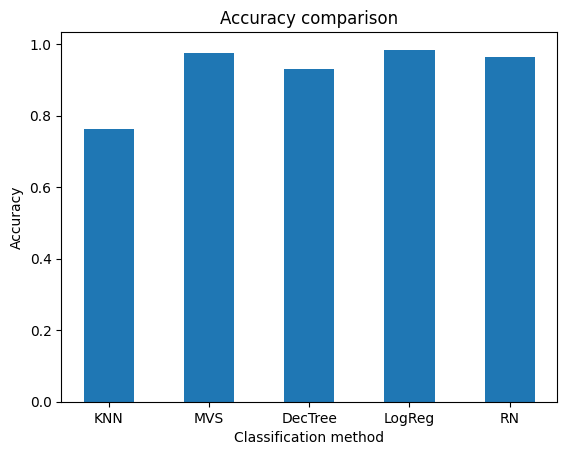

In [166]:
import matplotlib.pyplot as plt

methods = ['KNN', 'MVS', 'DecTree', 'LogReg', 'RN']
print(accuracies)
print(methods)

plt.bar(methods, accuracies, width = 0.5)

plt.title('Accuracy comparison')
plt.xlabel('Classification method')
plt.ylabel('Accuracy')

plt.show()


[2.039361000061035, 120.99692296981812, 11.422174215316772, 6.522223234176636, 29.903958559036255]
['KNN', 'MVS', 'DecTree', 'LogReg', 'RN']


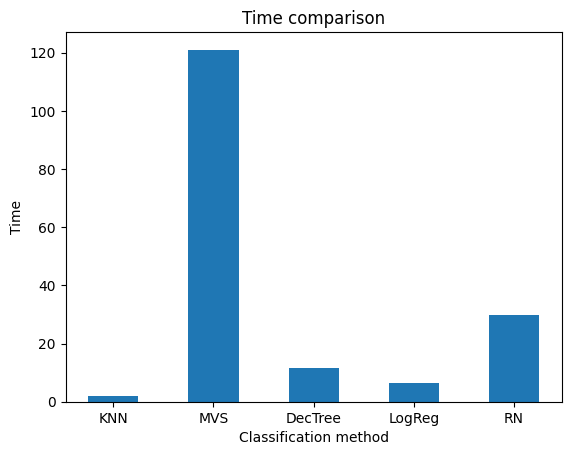

In [168]:
import matplotlib.pyplot as plt

methods = ['KNN', 'MVS', 'DecTree', 'LogReg', 'RN']
print(Time)
print(methods)

plt.bar(methods, Time, width=0.5)

plt.title('Time comparison')
plt.xlabel('Classification method')
plt.ylabel('Time')

plt.show()
